<a href="https://colab.research.google.com/github/fabriciosantana/mcdia/blob/main/01-icd/assignments/02-final/02-analisar-discursos-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de discursos da 56ª Legislatura (2019-2023) do plenário do Senado Federal

Fabricio Fernandes Santana  
Disciplina: Fundamentos da Ciência de Dados no Setor Público - 2025.2


## 1. Introdução
Este projeto analisa integralmente os discursos proferidos no plenário do Senado Federal durante a 56ª Legislatura (2019-2023). A investigação combina preparação de dados, análises descritivas, modelagem supervisionada para estimar o partido do orador a partir do texto e modelagem não supervisionada para mapear temas latentes. A questão orientadora é dupla: verificar se o conteúdo textual distingue legendas de forma robusta e, simultaneamente, se os tópicos emergentes revelam agendas que corroboram ou tensionam o posicionamento declarado dos partidos.

### 1.1 Problema público, narrativa e decisão
O Senado exerce papel central na formulação de políticas e na sinalização de prioridades das legendas. Sem monitoramento contínuo, torna-se difícil cobrar coerência entre os discursos parlamentares e a agenda oficial dos partidos, sobretudo em contextos de crise sanitária, recuperação econômica e disputa eleitoral. Este trabalho propõe usar dados abertos de pronunciamentos tanto para estimar o partido provável pelo conteúdo (abordagem supervisionada) quanto para identificar temas dominantes sem rótulos (abordagem não supervisionada), oferecendo um mecanismo de vigilância cívica sobre o alinhamento entre fala, programa partidário e agenda efetivamente debatida.

## 2. Análise Descritiva Preliminar
O dataset proveniente do portal de Dados Abertos do Senado é carregado a partir do repositório público no Hugging Face. Antes de qualquer modelagem, são inspecionados tipos de dados, completude e distribuição temporal, de autoria e de partidos, de modo a contextualizar o corpus, orientar decisões de limpeza e alimentar de forma consistente tanto o classificador supervisionado quanto o modelo temático não supervisionado.

### 2.0 Referência de preparação de dados
A base deriva do portal Dados Abertos do Senado (56ª Legislatura). O pipeline documentado em `01-preparar-base-discursos.ipynb` executa extração via API, limpeza de HTML e acentuação, recorte temporal, deduplicação e padronização em CSV/Parquet publicada na Hugging Face. Garantias de qualidade incluem checagem de valores ausentes nas colunas-chave (`Data`, `TextoDiscursoIntegral`, `NomeAutor`, `Partido`), filtros de tamanho mínimo e normalização de codificação. A versão final é lida neste notebook para todas as análises subsequentes.

### 2.1 Importar Bibliotecas
As bibliotecas utilizadas cobrem manipulação de dados (pandas, numpy), visualização (matplotlib, seaborn), modelagem (scikit-learn) e acesso ao dataset (datasets/Hugging Face). Esse conjunto permite documentar integralmente a preparação e a análise no próprio notebook.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset
from datasets import load_dataset_builder
import re

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


### 2.2 Carregar Dados
O conjunto de discursos é recuperado diretamente do repositório no Hugging Face, garantindo reprodutibilidade. Em seguida, converte-se a coluna de data para `datetime` e exibe-se a dimensão do DataFrame para evidenciar a abrangência da legislatura analisada.

In [2]:
DATASET_HF_REPO = "fabriciosantana/discursos-senado-legislatura-56"
DATA_FILE_HF = {"train": "data/full/discursos_2019-02-01_2023-01-31.parquet"}

ds_builder = load_dataset_builder(DATASET_HF_REPO)
display(ds_builder.info)

dataset = load_dataset(DATASET_HF_REPO, data_files=DATA_FILE_HF)
df_raw = dataset["train"].to_pandas()
df_raw['Data'] = pd.to_datetime(df_raw['Data'], errors='coerce')

print(f'Linhas: {len(df_raw):,} | Colunas: {df_raw.shape[1]}')
df_raw.head()

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value('string'), 'CodigoPronunciamento': Value('string'), 'Casa': Value('string'), 'Data': Value('string'), 'Resumo': Value('string'), 'Indexacao': Value('string'), 'TextoIntegral': Value('string'), 'TextoIntegralTxt': Value('string'), 'UrlTextoBinario': Value('string'), 'TipoAutor': Value('string'), 'FuncaoAutor': Value('string'), 'NomeAutor': Value('string'), 'CodigoParlamentar': Value('string'), 'Partido': Value('string'), 'UF': Value('string'), 'TipoUsoPalavra.Codigo': Value('string'), 'TipoUsoPalavra.Sigla': Value('string'), 'TipoUsoPalavra.Descricao': Value('string'), 'TipoUsoPalavra.IndicadorAtivo': Value('string'), 'Publicacoes.Publicacao': List({'DataPublicacao': Value('string'), 'FontePublicacao': Value('string'), 'PaginaFinal': Value('string'), 'PaginaInicial': Value('string'), 'SiglaFonte': Value('string'), 'TipoPublicacao': Value('string'), 'UrlDiario': Value('string')}), 'Apartes.Aparteante'

Linhas: 15,729 | Colunas: 30


,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,Apartes.Aparteante,__janela_inicio,__janela_fim,CargoAutor,OrgaoAutor,PaisAutor,TextoDiscursoIntegral,ok,status,msg
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,
3,451203,451203,Senado Federal,2019-02-27,Expectativa com o início dos trabalhos no âmbi...,"EXPECTATIVA, INICIO, TRABALHO, COMISSÕES, SENA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. CONFÚCIO MOURA (Bloco Parlamentar Unidos...,True,200,
4,451202,451202,Senado Federal,2019-02-27,Relato da origem e das motivações do Projeto d...,"COMENTARIO, ORIGEM, MOTIVO, PROJETO DE LEI, OB...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. RODRIGO PACHECO (Bloco Parlamentar Vangu...,True,200,


### 2.2.1 Analisar a estrutura do dataframe
A inspeção de `shape` e `info()` documenta o número de registros, colunas e respectivos tipos, além de indicar campos com valores ausentes. Esse diagnóstico inicial fundamenta as etapas posteriores de higienização.

In [3]:
print(f'Linhas: {df_raw.shape[0]:,} | Colunas: {df_raw.shape[1]}')
df_raw.info()


Linhas: 15,729 | Colunas: 30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15729 entries, 0 to 15728
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             15729 non-null  object        
 1   CodigoPronunciamento           15729 non-null  object        
 2   Casa                           15729 non-null  object        
 3   Data                           15729 non-null  datetime64[ns]
 4   Resumo                         15672 non-null  object        
 5   Indexacao                      15694 non-null  object        
 6   TextoIntegral                  15729 non-null  object        
 7   TextoIntegralTxt               15729 non-null  object        
 8   UrlTextoBinario                15729 non-null  object        
 9   TipoAutor                      15729 non-null  object        
 10  FuncaoAutor                    15729 non-null  object

### 2.3 Obter uma visão geral dos tipos de dados e da quantidade de valores ausentes por coluna
Constrói-se uma tabela que relaciona cada coluna ao seu tipo, número absoluto e percentual de ausências, ordenada pelos casos mais críticos. A leitura dessa tabela prioriza quais variáveis exigem tratamento e evita surpresas no fluxo de modelagem.

In [4]:
overview = (
    pd.DataFrame({
        'dtype': df_raw.dtypes.astype(str),
        'missing': df_raw.isna().sum()
    })
    .assign(missing_pct=lambda df: (df['missing'] / len(df_raw) * 100).round(2))
    .sort_values('missing', ascending=False)
)
overview.head(10)


,dtype,missing,missing_pct
PaisAutor,object,15632,99.38
OrgaoAutor,object,14918,94.84
Apartes.Aparteante,object,14861,94.48
CargoAutor,object,14825,94.25
Partido,object,2074,13.19
CodigoParlamentar,object,2074,13.19
UF,object,2074,13.19
Publicacoes.Publicacao,object,734,4.67
Resumo,object,57,0.36
Indexacao,object,35,0.22


### 2.4 Sintetizar indicadores-chave sobre o volume e a diversidade do corpus de discursos
São computadas contagens de discursos, autores, partidos, unidades da federação e datas únicas. Esses indicadores situam a escala do corpus e mostram a diversidade de atores representados na legislatura.

In [5]:
metrics = pd.Series({
    'Discursos': len(df_raw),
    'Autores unicos': df_raw['NomeAutor'].nunique(),
    'Partidos unicos': df_raw['Partido'].nunique(),
    'Estados representados': df_raw['UF'].nunique(),
    'Datas distintas': df_raw['Data'].nunique()
})
metrics.to_frame('valor')


,valor
Discursos,15729
Autores unicos,1794
Partidos unicos,32
Estados representados,27
Datas distintas,604


### 2.5. Detalhar as colunas com maior incidência de valores faltantes
A contagem e o percentual de `NaN` por coluna permitem priorizar o tratamento de campos críticos, especialmente aqueles que impactam a construção de variáveis de tempo, autor e partido.

In [6]:
missing = (
    df_raw.isna()
        .sum()
        .to_frame('faltantes')
        .assign(percentual=lambda df: (df['faltantes'] / len(df_raw) * 100).round(2))
        .sort_values('faltantes', ascending=False)
)
missing.head(12)


,faltantes,percentual
PaisAutor,15632,99.38
OrgaoAutor,14918,94.84
Apartes.Aparteante,14861,94.48
CargoAutor,14825,94.25
Partido,2074,13.19
CodigoParlamentar,2074,13.19
UF,2074,13.19
Publicacoes.Publicacao,734,4.67
Resumo,57,0.36
Indexacao,35,0.22


### 2.6 Preparar atributos derivados que serão usados na análise exploratória e no modelo supervisionado
O conjunto recebe colunas auxiliares (ano, mês, dia da semana) e medidas de comprimento textual. Essa engenharia de atributos facilita agregações temporais e a filtragem de discursos com tamanho inadequado para análise.

In [7]:
df = df_raw.copy()

df['ano'] = df['Data'].dt.year
# Representacao mensal padronizada
mes_periodo = df['Data'].dt.to_period('M')
df['mes'] = mes_periodo.dt.to_timestamp()

dias_semana_pt = {
    0: 'Segunda',
    1: 'Terca',
    2: 'Quarta',
    3: 'Quinta',
    4: 'Sexta',
    5: 'Sabado',
    6: 'Domingo'
}
df['dia_semana'] = df['Data'].dt.dayofweek.map(dias_semana_pt)

# Limpar e medir o texto integral
texto_coluna = 'TextoDiscursoIntegral'
df[texto_coluna] = df[texto_coluna].fillna('').str.strip()
df['texto_len_palavras'] = df[texto_coluna].str.split().str.len()
df['texto_len_caracteres'] = df[texto_coluna].str.len()

df.head(3)


,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,PaisAutor,TextoDiscursoIntegral,ok,status,msg,ano,mes,dia_semana,texto_len_palavras,texto_len_caracteres
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,,2019,2019-02-01,Quarta,873,5650
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,,2019,2019-02-01,Quarta,1588,10113
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,,2019,2019-02-01,Quarta,4682,28440


### 2.7. Analisar a evolução temporal do número de discursos
A série mensal de pronunciamentos revela sazonalidades legislativas, destacando picos em momentos de votações relevantes e reduções em períodos de recesso.

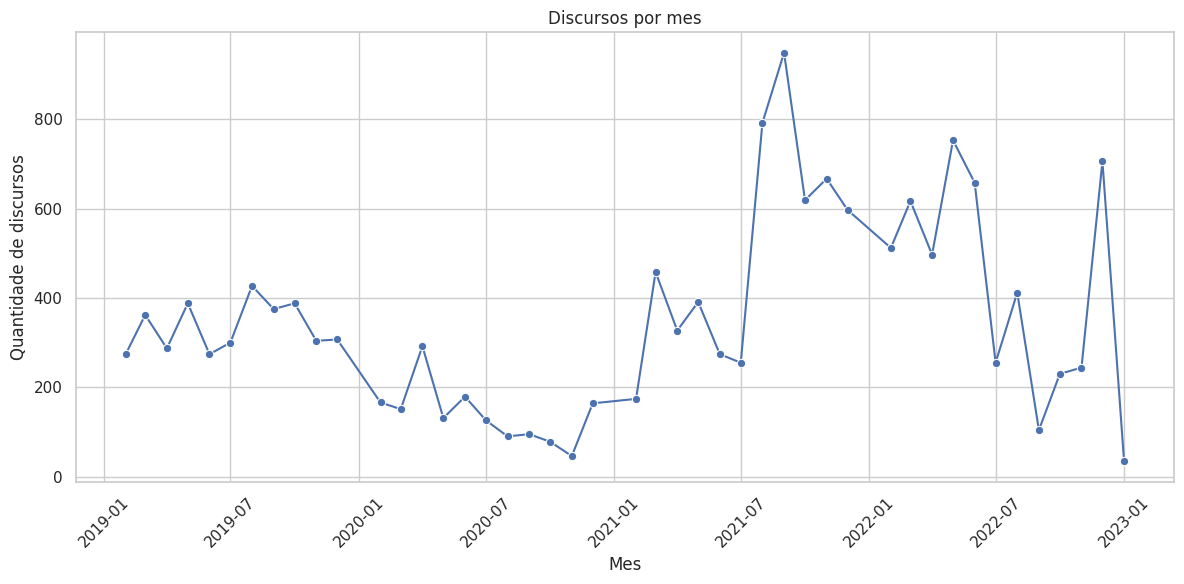

In [8]:
discursos_por_mes = (
    df.groupby('mes')
      .size()
      .reset_index(name='discursos')
      .sort_values('mes')
)

fig, ax = plt.subplots()
sns.lineplot(data=discursos_por_mes, x='mes', y='discursos', ax=ax, marker='o')
ax.set(title='Discursos por mes', xlabel='Mes', ylabel='Quantidade de discursos')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


### 2.8. Identificar os autores mais atuantes no plenário
O ranqueamento de oradores evidencia senadores com maior presença na tribuna, permitindo relacionar protagonismo individual a pautas específicas da legislatura.

/tmp/ipykernel_3062/314848631.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_autores, x='discursos', y='NomeAutor', palette='Blues_r', ax=ax)


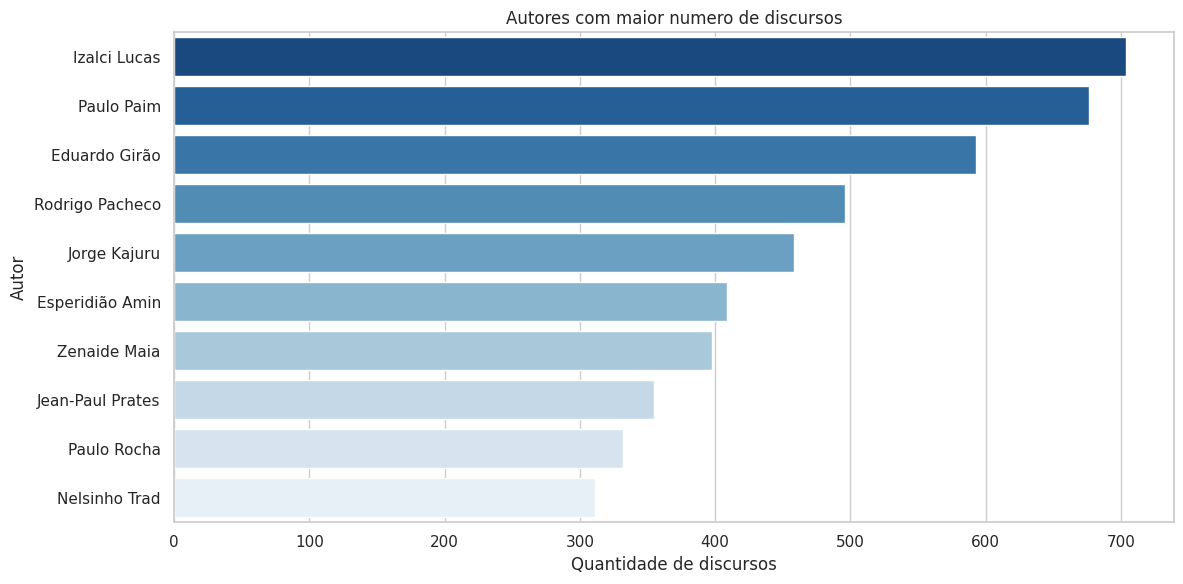

In [9]:
top_autores = (
    df.groupby('NomeAutor')
      .size()
      .sort_values(ascending=False)
      .head(10)
      .reset_index(name='discursos')
)

fig, ax = plt.subplots()
sns.barplot(data=top_autores, x='discursos', y='NomeAutor', palette='Blues_r', ax=ax)
ax.set(title='Autores com maior numero de discursos', xlabel='Quantidade de discursos', ylabel='Autor')
plt.tight_layout()


### 2.9. Mapear os partidos com maior presença nos discursos
O agrupamento por sigla confirma a predominância de partidos com bancadas amplas e atuação destacada. Essa leitura orienta a seleção de classes para o modelo supervisionado.

/tmp/ipykernel_3062/1539680874.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_partidos, x='discursos', y='Partido', palette='viridis', ax=ax)


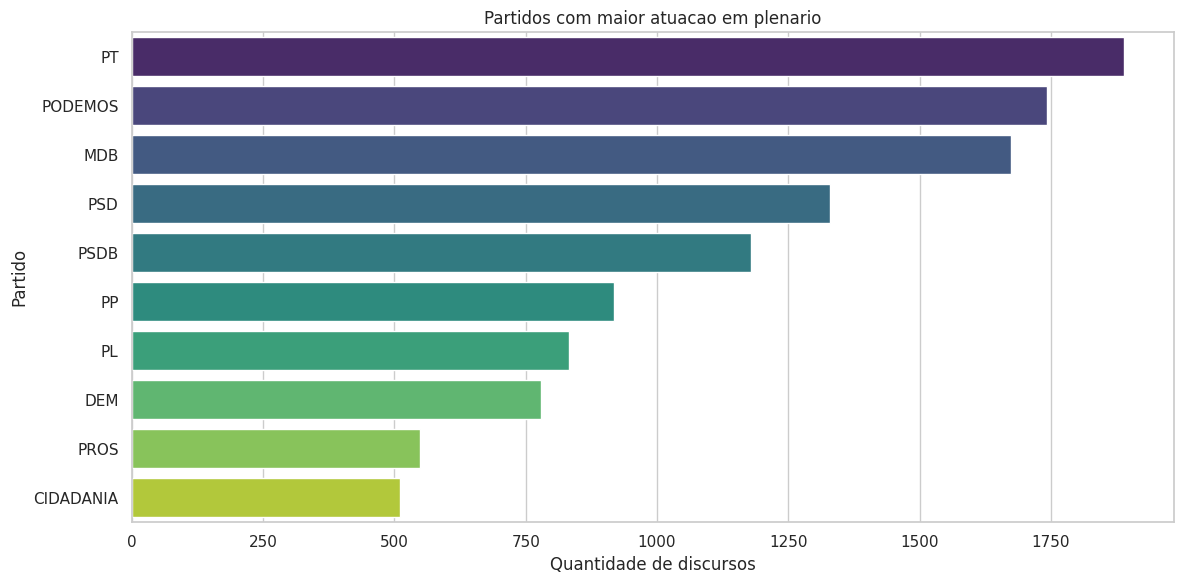

In [10]:
top_partidos = (
    df['Partido']
      .replace('', np.nan)
      .dropna()
      .value_counts()
      .head(10)
      .rename_axis('Partido')
      .reset_index(name='discursos')
)

fig, ax = plt.subplots()
sns.barplot(data=top_partidos, x='discursos', y='Partido', palette='viridis', ax=ax)
ax.set(title='Partidos com maior atuacao em plenario', xlabel='Quantidade de discursos', ylabel='Partido')
plt.tight_layout()


### 2.10. Comparar a intensidade anual de discursos dos partidos mais frequentes
Filtram-se os partidos no topo do ranking e gera-se tabela dinâmica por ano, permitindo contrastar variações de engajamento legislativo ao longo do tempo entre essas siglas.

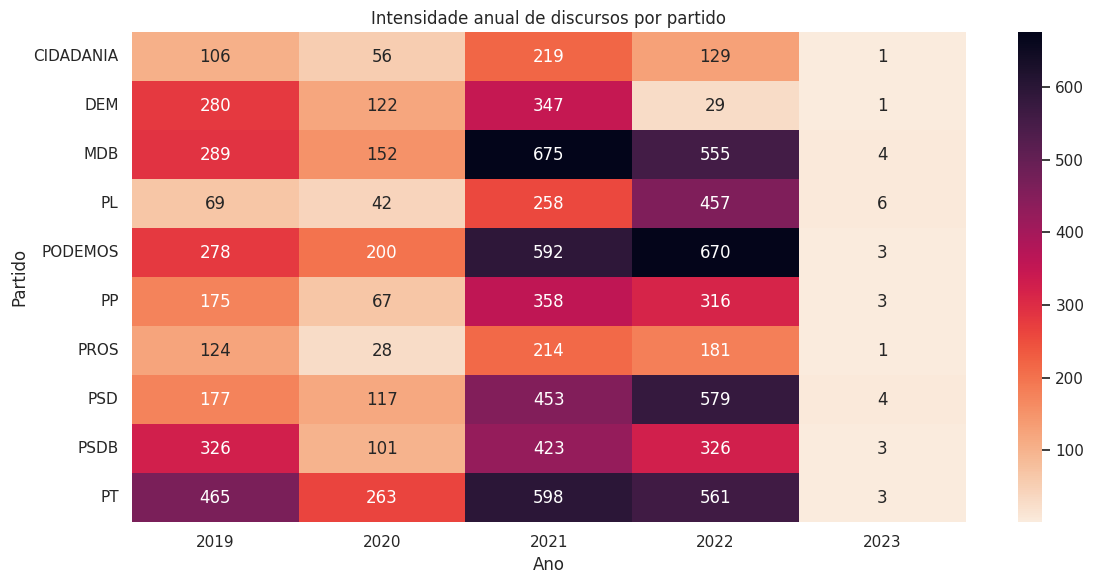

In [11]:
heatmap_data = (
    df[df['Partido'].isin(top_partidos['Partido'])]
      .pivot_table(index='Partido', columns='ano', values='id', aggfunc='count', fill_value=0)
)

fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='rocket_r', ax=ax)
ax.set(title='Intensidade anual de discursos por partido', xlabel='Ano', ylabel='Partido')
plt.tight_layout()


### 2.11. Avaliar a distribuição do tamanho dos discursos em palavras
Um histograma com 60 classes descreve a densidade do comprimento textual, destacando a cauda longa e a presença de pronunciamentos extensos que podem influenciar a vetorização.

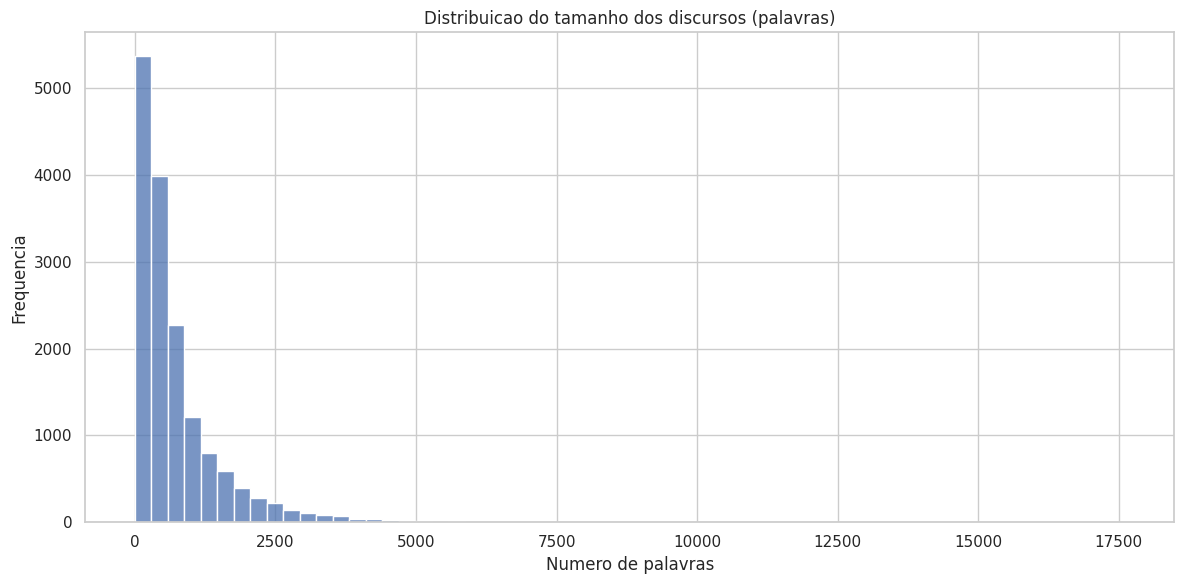

In [12]:
fig, ax = plt.subplots()
sns.histplot(df['texto_len_palavras'], bins=60, ax=ax)
ax.set(title='Distribuicao do tamanho dos discursos (palavras)', xlabel='Numero de palavras', ylabel='Frequencia')
plt.tight_layout()


### 2.12. Comparar o comprimento dos discursos entre os partidos mais frequentes
Boxplots para os partidos líderes expõem diferenças de mediana e dispersão no tamanho dos discursos, sinalizando estilos discursivos mais concisos ou prolixos por legenda.

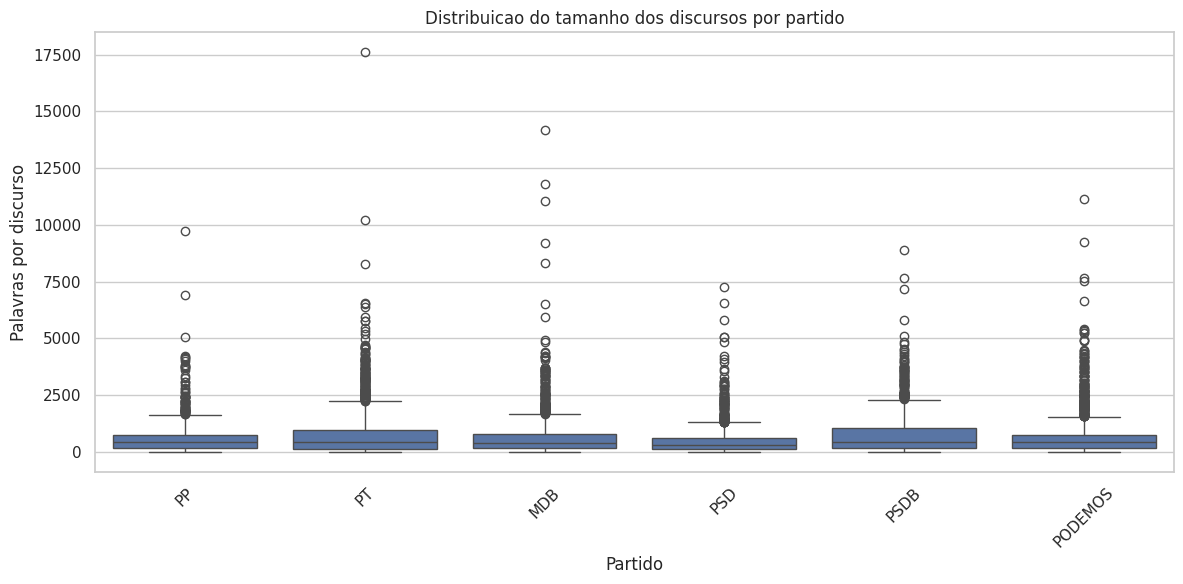

In [13]:
partidos_para_boxplot = top_partidos['Partido'].head(6).tolist()

fig, ax = plt.subplots()
sns.boxplot(
    data=df[df['Partido'].isin(partidos_para_boxplot)],
    x='Partido',
    y='texto_len_palavras',
    ax=ax
)
ax.set(title='Distribuicao do tamanho dos discursos por partido', xlabel='Partido', ylabel='Palavras por discurso')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


### 2.13. Quantificar discursos por ano
A agregação anual mostra como o volume de pronunciamentos se distribui ao longo da legislatura, permitindo comparar períodos pré e pós-pandemia e anos eleitorais.

,ano,discursos
0,2019,3686
1,2020,1518
2,2021,5503
3,2022,4988
4,2023,34


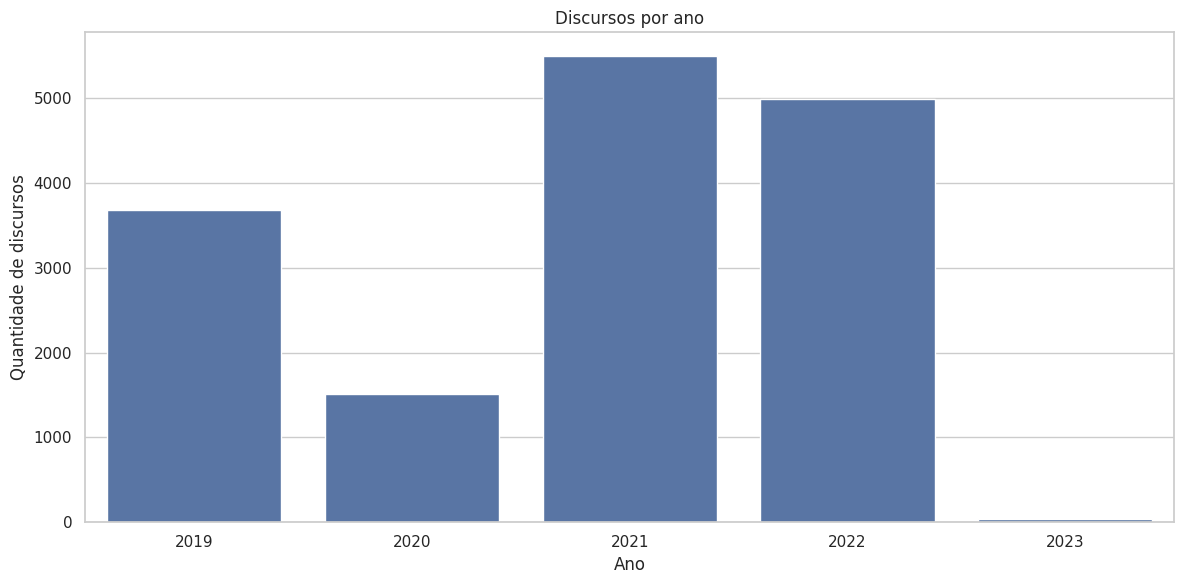

In [14]:
discursos_por_ano = (
    df.dropna(subset=['ano'])
      .groupby('ano')
      .size()
      .reset_index(name='discursos')
      .sort_values('ano')
)

discursos_por_ano['ano'] = discursos_por_ano['ano'].astype(int)
plot_discursos_por_ano = discursos_por_ano.assign(ano=discursos_por_ano['ano'].astype(str))

fig, ax = plt.subplots()
sns.barplot(data=plot_discursos_por_ano, x='ano', y='discursos', color='C0', ax=ax)
ax.set(title='Discursos por ano', xlabel='Ano', ylabel='Quantidade de discursos')
plt.tight_layout()

discursos_por_ano


### 2.14. Distribuição de discursos por dia da semana
A contagem por dia da semana confirma o ritmo do plenário, concentrado em terças, quartas e quintas-feiras, em consonância com o calendário legislativo.

,dia_semana,discursos
0,Segunda,2070
1,Terça,4421
2,Quarta,4667
3,Quinta,2932
4,Sexta,1591


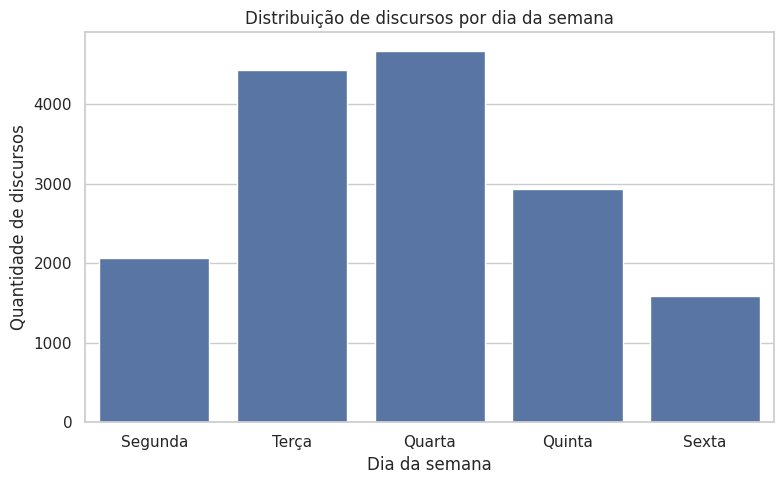

In [15]:

dias_semana_ordem = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta']
distribuicao_semana = (
    df.dropna(subset=['dia_semana'])
      .assign(dia_semana=lambda s: s['dia_semana'].replace({
          'Terca': 'Terça', 'Quarta': 'Quarta', 'Quinta': 'Quinta',
          'Sexta': 'Sexta', 'Sabado': 'Sábado', 'Domingo': 'Domingo'
      }))
      .groupby('dia_semana')
      .size()
      .reindex(dias_semana_ordem, fill_value=0)
      .rename('discursos')
      .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=distribuicao_semana, x='dia_semana', y='discursos', color='C0', ax=ax)
ax.set(title='Distribuição de discursos por dia da semana', xlabel='Dia da semana', ylabel='Quantidade de discursos')
plt.tight_layout()

distribuicao_semana


### 2.15. Estados com mais discursos registrados
A agregação por unidade da federação identifica quais representações estaduais utilizam mais a tribuna, trazendo à tona lideranças regionais e eventuais desequilíbrios de participação.

,UF,discursos
0,RS,1128
1,DF,1056
2,RN,839
3,MG,804
4,CE,708
5,MS,625
6,GO,619
7,MT,571
8,SC,565
9,PR,564


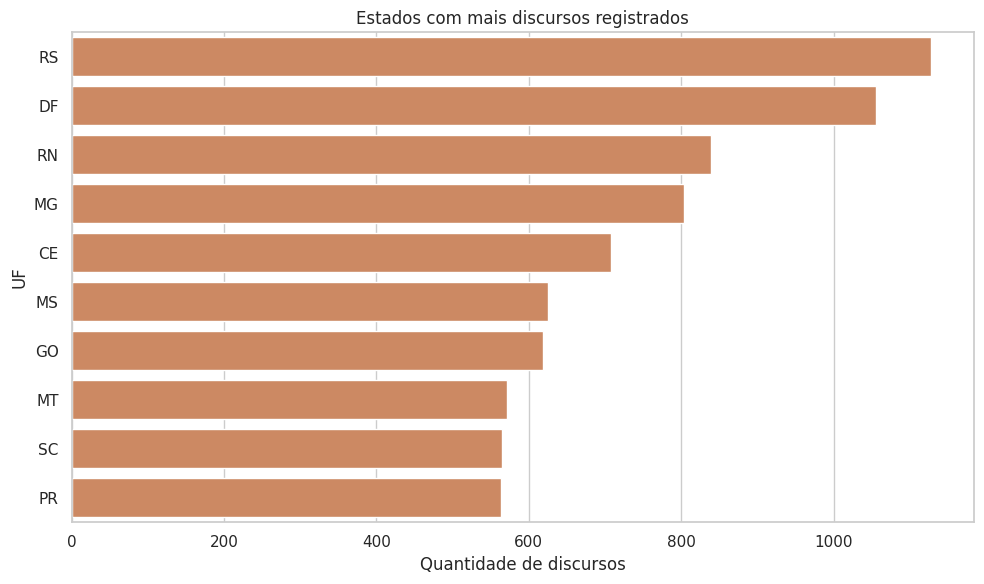

In [16]:

discursos_por_uf = (
    df['UF']
      .replace('', 'Não informado')
      .value_counts()
      .head(10)
      .rename('discursos')
      .reset_index()
      .rename(columns={'index': 'UF'})
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=discursos_por_uf, x='discursos', y='UF', color='C1', ax=ax)
ax.set(title='Estados com mais discursos registrados', xlabel='Quantidade de discursos', ylabel='UF')
plt.tight_layout()

discursos_por_uf


### 2.16. Principais tipos de uso da palavra
A coluna de tipo de uso diferencia comunicações, apartes e demais atos regimentais. Mapear sua frequência mostra o perfil predominante de intervenção no plenário.

,TipoUsoPalavra.Descricao,discursos
0,Discurso,5668
1,Pela ordem,2620
2,Discussão,1618
3,Orientação à bancada,1340
4,Não classificado,906
5,Fala da Presidência,720
6,Exposição de convidado,716
7,Pela Liderança,643
8,Como Relator,409
9,Como Relator - Para proferir parecer,360


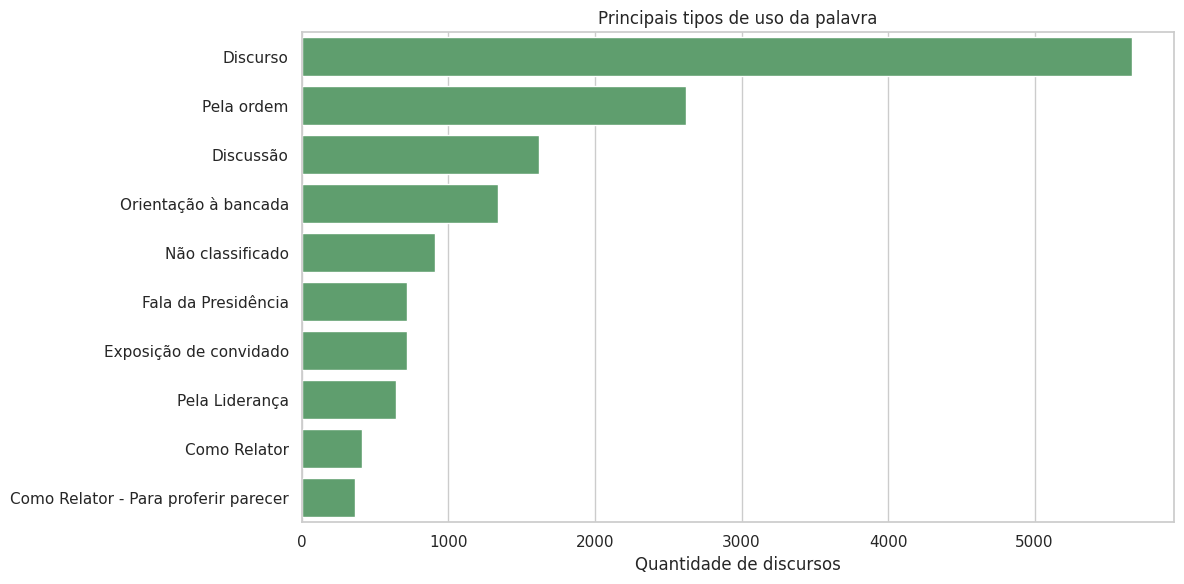

In [17]:
tipo_uso_palavra = (
    df['TipoUsoPalavra.Descricao']
      .fillna('Não informado')
      .replace('', 'Não informado')
      .value_counts()
      .head(10)
      .rename('discursos')
      .reset_index()
      .rename(columns={'index': 'Tipo de uso'})
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=tipo_uso_palavra, x='discursos', y='TipoUsoPalavra.Descricao', color='C2', ax=ax)
ax.set(title='Principais tipos de uso da palavra', xlabel='Quantidade de discursos', ylabel='')
plt.tight_layout()

tipo_uso_palavra


### 2.17. Preparar colunas textuais para inspeção
As variáveis textuais são normalizadas para strings vazias em casos de ausência, prevenindo falhas em operações posteriores e mantendo consistência na limpeza.

In [18]:

colunas_textuais = [
    'Resumo', 'Indexacao', 'TextoIntegral', 'TextoIntegralTxt',
    'TextoDiscursoIntegral', 'TipoUsoPalavra.Descricao', 'TipoUsoPalavra.Sigla',
    'TipoUsoPalavra.Codigo', 'TipoUsoPalavra.IndicadorAtivo',
    'Publicacoes.Publicacao', 'Apartes.Aparteante', 'CargoAutor',
    'OrgaoAutor', 'PaisAutor'
]

for coluna in colunas_textuais:
    if coluna in df.columns:
        df[coluna] = df[coluna].fillna('').astype(str)

qtd_sem_texto = (df['TextoDiscursoIntegral'].str.strip() == '').sum()
print(f'Discursos sem texto integral disponível: {qtd_sem_texto}')

preview_sem_texto = df[df['TextoDiscursoIntegral'].str.strip() == ''][['id', 'NomeAutor', 'Data']].head()
preview_sem_texto


Discursos sem texto integral disponível: 690


,id,NomeAutor,Data
1607,455207,Marcelo Castro,2019-06-11
2803,461050,Confúcio Moura,2019-11-01
3365,462708,Jorginho Mello,2019-11-19
3366,462707,CARLOS ALEXANDRE DA COSTA,2019-11-19
3367,462705,ALCIDE ANDRADE,2019-11-19


### 2.18. Medir palavras e caracteres por discurso
Indicadores de comprimento para textos integrais e resumos ajudam a detectar outliers de tamanho e servem de base para filtros mínimos de qualidade textual.

In [19]:

df['texto_len_palavras'] = df['TextoDiscursoIntegral'].str.split().str.len()
df['texto_len_caracteres'] = df['TextoDiscursoIntegral'].str.len()
df['resumo_len_palavras'] = df['Resumo'].str.split().str.len()

df[['id', 'texto_len_palavras', 'texto_len_caracteres', 'resumo_len_palavras']].head()


,id,texto_len_palavras,texto_len_caracteres,resumo_len_palavras
0,451286,873,5650,46
1,451285,1588,10113,31
2,451205,4682,28440,57
3,451203,3515,20792,17
4,451202,5774,35028,22


### 2.19. Estatísticas descritivas do tamanho dos discursos
Resumo de estatísticas (mediana, quartis e amplitude) reforça a heterogeneidade do corpus e auxilia na escolha de cortes de tamanho para a modelagem.

In [20]:

tamanho_discursos = pd.DataFrame({
    'palavras': df['texto_len_palavras'].describe().round(2),
    'caracteres': df['texto_len_caracteres'].describe().round(2)
})

tamanho_discursos


,palavras,caracteres
count,15729.00,15729.00
mean,727.83,4450.81
std,880.17,5326.02
min,0.00,0.00
25%,195.00,1201.00
50%,464.00,2842.00
75%,912.00,5595.00
max,17602.00,106610.00


### 2.20. Nuvem de palavras dos discursos
A nuvem de palavras sintetiza o vocabulário dominante, excluindo termos genéricos por meio de uma lista ampliada de stopwords em português, de modo a ressaltar temas substantivos.

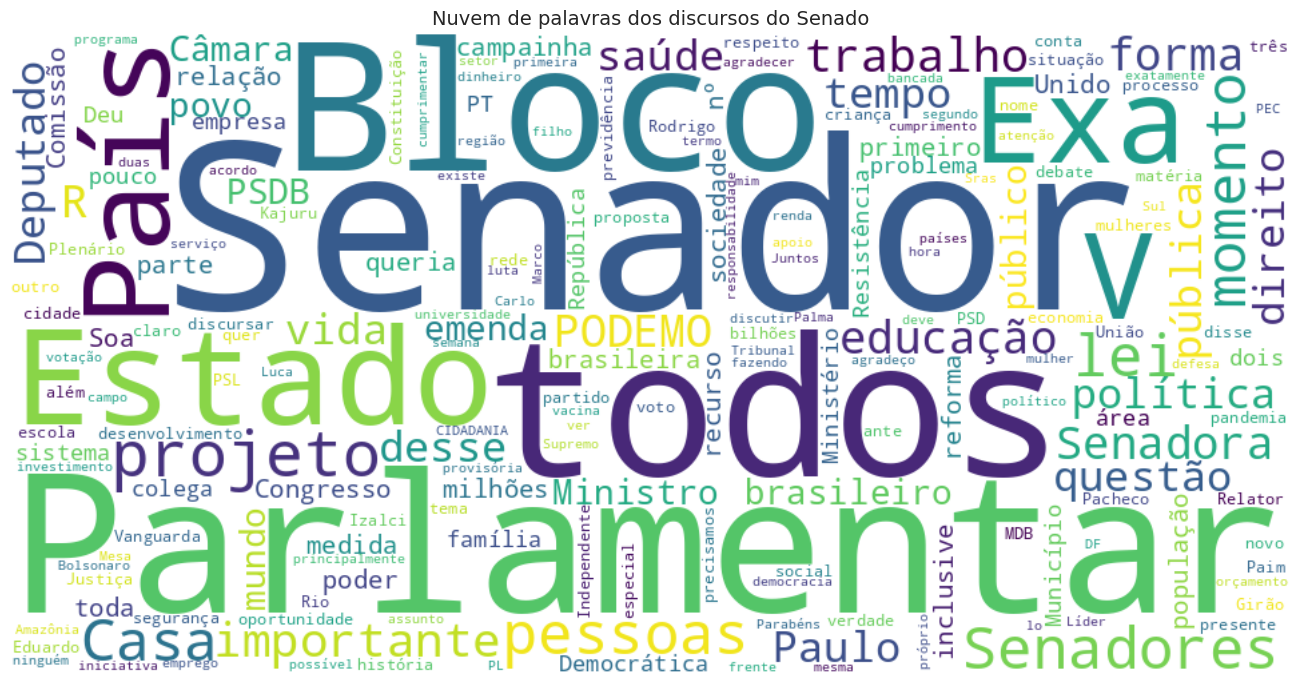

In [21]:

try:
    from wordcloud import WordCloud
    import nltk
    from nltk.corpus import stopwords as nltk_stopwords
except ImportError as err:
    print('Bibliotecas opcionais ausentes. Instale `wordcloud` e `nltk` para gerar a nuvem de palavras.')
else:
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        try:
            nltk.download('stopwords', quiet=True)
        except Exception as download_err:
            print('Não foi possível baixar as stopwords do NLTK:', download_err)
    try:
        stopwords_pt = set(nltk_stopwords.words('portuguese'))
    except LookupError:
        stopwords_pt = set()
    stopwords_extra = {
        'senhor', 'senhora', 'senhores', 'senhoras', 'presidente', 'presidência',
        'senado', 'federal', 'brasil', 'brasileiros', 'brasileiras', 'palavra',
        'sessão', 'ordem', 'anos', 'ano', 'quero', 'fazer', 'feito', 'gente',
        'nosso', 'nossa', 'nossos', 'nossas', 'dizer', 'diz', 'fez', 'governo',
        'nacional', 'discurso', 'então', 'sr', 'pode', 'aqui', 'grande', 'pessoa', 'todo',
        'hoje', 'dia', 'dessa', 'lá', 'exmo', 'vai', 'porque', 'agora', 'ainda',
        'sempre', 'sobre', 'vamos', 'ter', 'bem', 'outra', 'muita', 'muitas', 'certeza',
        'apenas', 'caso', 'ontem', 'sim', 'desde', 'realmente', 'aí', 'sra',
        'todas', 'dias', 'amigo', 'tudo', 'outras', 'vez', 'número', 'vou', 'fala',
        'precisa', 'possa', 'sabe', 'neste', 'junto', 'art', 'assim', 'maior', 'mil',
        'alguma', 'falando', 'portanto', 'dentro', 'fato', 'desta', 'nessa', 'nesse',
        'onde', 'nova', 'quanto', 'disso', 'srs', 'ali', 'bom', 'coisa', 'outros',
        'vezes', 'tanto', 'deste', 'nesta', 'têm', 'cada', 'faz', 'sendo', 'boa',
        'menos', 'último', 'vão', 'meio', 'nada', 'dado', 'quase', 'gostaria',
        'importância', 'alguns', 'ponto', 'qualquer', 'pois', 'sentido', 'vem', 'tão',
        'dá', 'partir', 'contra', 'dar', 'sei', 'melhor', 'nunca', 'através', 'deixar',
        'obrigado', 'obrigada', 'acho', 'nenhum', 'exemplo', 'mínimo', 'lado', 'muitos', 'falar'
    }
    stopwords = stopwords_pt.union(stopwords_extra)

    textos = df['TextoDiscursoIntegral'].dropna()
    textos = textos[textos.str.len() > 0]

    if textos.empty:
        print('Não há textos integrais disponíveis para gerar a nuvem de palavras.')
    else:
        corpus = ' '.join(textos.values)
        wordcloud = WordCloud(
            width=960,
            height=480,
            background_color='white',
            max_words=200,
            collocations=False,
            stopwords=stopwords
        ).generate(corpus)

        fig, ax = plt.subplots(figsize=(14, 7))
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title('Nuvem de palavras dos discursos do Senado', fontsize=14)
        plt.tight_layout()


### 2.21. Principais achados da análise descritiva
O corpus apresenta concentração de discursos entre 2019 e 2022, com retomada vigorosa após a fase aguda da pandemia e protagonismo de partidos como PT, Podemos e MDB. A distribuição semanal confirma terça a quinta-feira como eixo da atividade, e as análises por autor e UF evidenciam lideranças regionais. O tamanho mediano de aproximadamente 460 palavras, aliado à dispersão elevada, sugere a necessidade de vetorização que lide bem com documentos de extensão variável.

## 3. Divisão dos Dados
A tarefa supervisionada consiste em classificar o partido com base no texto integral. O DataFrame é filtrado para manter pronunciamentos válidos, assegurar presença de rótulo e delimitar o conjunto a classes com representatividade suficiente.

### 3.1. Construir uma base textualmente limpa e pronta para modelagem
Selecionaram-se colunas relevantes, removeram-se registros incompletos, aplicou-se limpeza para eliminar dígitos e pontuação e filtraram-se discursos com menos de 20 palavras. A análise foi limitada aos oito partidos mais frequentes; do texto foram removidas referências explícitas ao autor, ao partido e à UF para mitigar vazamento antes da vetorização.

A escolha dos oito partidos (DEM, MDB, PL, PODEMOS, PP, PSD, PSDB, PT) reflete a intenção de focar em classes com volume suficiente para treino e avaliação equilibrados, evitando distorções de métricas por baixa representatividade.

In [22]:
colunas_modelo = ['Partido', 'UF', 'NomeAutor', 'Data', 'TextoDiscursoIntegral']

def limpar_texto_basico(texto: str) -> str:
    """Normaliza texto em minúsculas e remove ruídos básicos."""
    texto = texto.lower()
    texto = re.sub(r'\d+', ' ', texto)
    texto = re.sub(r'[^\w\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

base_modelo = (
    df[colunas_modelo]
      .dropna(subset=['Partido', 'TextoDiscursoIntegral'])
      .copy()
)

base_modelo['texto'] = base_modelo['TextoDiscursoIntegral'].str.strip()
base_modelo = base_modelo[base_modelo['texto'].str.len() > 0]
base_modelo['n_palavras'] = base_modelo['texto'].str.split().str.len()
base_modelo = base_modelo[base_modelo['n_palavras'] >= 20]

partidos_selecionados = base_modelo['Partido'].value_counts().head(8).index.tolist()
base_modelo = base_modelo[base_modelo['Partido'].isin(partidos_selecionados)].copy()

# Remove padrões que vazam a resposta (siglas partidárias, UF e o nome completo do autor)
partidos_lista = sorted(base_modelo['Partido'].dropna().str.lower().unique().tolist())
ufs_lista = sorted(base_modelo['UF'].dropna().str.lower().unique().tolist())
regex_partidos = re.compile(r'\b(' + '|'.join(map(re.escape, partidos_lista)) + r')\b') if partidos_lista else None
regex_ufs = re.compile(r'\b(' + '|'.join(map(re.escape, ufs_lista)) + r')\b') if ufs_lista else None

def remover_referencias(texto: str, autor: str, partido: str, uf: str) -> str:
    texto = limpar_texto_basico(texto)
    if autor:
        texto = re.sub(re.escape(str(autor).lower()), ' ', texto)
        for token in str(autor).lower().split():
            texto = re.sub(rf'\b{re.escape(token)}\b', ' ', texto)
    if regex_partidos:
        texto = regex_partidos.sub(' ', texto)
    if regex_ufs:
        texto = regex_ufs.sub(' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

base_modelo['texto_limpo'] = base_modelo.apply(
    lambda row: remover_referencias(row['texto'], row['NomeAutor'], row['Partido'], row['UF']),
    axis=1
)

base_modelo[['Partido', 'UF', 'NomeAutor', 'n_palavras', 'texto_limpo']].head()

,Partido,UF,NomeAutor,n_palavras,texto_limpo
0,PP,PI,Ciro Nogueira,873,senado federal sf secretaria geral da mesa sec...
1,PT,RS,Paulo Paim,1588,senado federal sf secretaria geral da mesa sec...
3,MDB,RO,Confúcio Moura,3515,o sr bloco parlamentar unidos pelo brasil para...
4,DEM,MG,Rodrigo Pacheco,5774,o sr bloco parlamentar vanguarda para discursa...
5,PP,RS,Luis Carlos Heinze,5049,o sr bloco parlamentar unidos pelo brasil para...


### 3.2 Verificar a distribuição final de amostras por partido após o balanceamento
A distribuição por classe é revisada para confirmar o efeito dos filtros e subsidiar decisões de balanceamento controlado no conjunto de treino.

In [23]:
distribuicao_filtrada = base_modelo['Partido'].value_counts().to_frame('total_pos_filtro')
distribuicao_filtrada

,total_pos_filtro
Partido,
PT,1662
MDB,1595
PODEMOS,1566
PSD,1288
PSDB,1140
PP,906
PL,810
DEM,722


### 3.3 Separar os dados em conjuntos de treino e teste preservando a proporção entre classes
A divisão estratificada em treino e teste mantém a proporção original de partidos. Qualquer ajuste de balanceamento é aplicado apenas no treino, preservando a integridade do teste para medir desempenho realista.

In [24]:
# Divide antes de balancear para evitar vazamento
df_treino, df_teste = train_test_split(
    base_modelo[['Partido', 'texto_limpo']],
    test_size=0.2,
    stratify=base_modelo['Partido'],
    random_state=42
)

def undersample_por_partido(df_balancear, max_por_partido=800):
    amostras = []
    for partido, grupo in df_balancear.groupby('Partido'):
        tamanho = min(len(grupo), max_por_partido)
        amostras.append(grupo.sample(n=tamanho, random_state=42))
    return pd.concat(amostras).reset_index(drop=True)

df_treino_bal = undersample_por_partido(df_treino, max_por_partido=800)

X_train = df_treino_bal['texto_limpo']
y_train = df_treino_bal['Partido']

X_test = df_teste['texto_limpo']
y_test = df_teste['Partido']

print(f'Amostras treino balanceadas: {len(X_train)} | Amostras teste (originais): {len(X_test)}')
print('Distribuicao treino balanceado (top 5):')
print(y_train.value_counts().head())

distribuicao_partido = pd.DataFrame({
    'treino_balanceado': y_train.value_counts().sort_index(),
    'teste_original': y_test.value_counts().sort_index()
})
distribuicao_partido

Amostras treino balanceadas: 5951 | Amostras teste (originais): 1938
Distribuicao treino balanceado (top 5):
Partido
MDB        800
PODEMOS    800
PSDB       800
PSD        800
PT         800
Name: count, dtype: int64


,treino_balanceado,teste_original
Partido,,
DEM,578,144
MDB,800,319
PL,648,162
PODEMOS,800,313
PP,725,181
PSD,800,258
PSDB,800,228
PT,800,333


### Prevenção de vazamento de rótulo
As etapas de pré-processamento removem menções diretas ao partido, à UF e ao nome do orador antes da vetorização. O balanceamento ocorre somente após o `train_test_split`, garantindo que o conjunto de teste permaneça isolado de decisões tomadas no treino.

## 4. Pré-processamento dos Dados
O pipeline supervisionado emprega vetorização TF-IDF em n-gramas (1 a 2) para capturar padrões lexicais relevantes. A limpeza textual preserva acentuação e elimina ruídos, equilibrando custo computacional e riqueza semântica para o português.

## 5. Construção e Escolha do Modelo
Quatro classificadores lineares são avaliados com a mesma representação TF-IDF: Regressão Logística, SVM linear, Multinomial Naive Bayes e Passive Aggressive. As métricas centrais são acurácia e F1 macro, priorizando equilíbrio entre classes com suportes distintos. Essa trilha supervisionada será posteriormente contraposta ao diagnóstico temático obtido via NMF para checar se a separação por partido se apoia em diferenças substantivas de agenda.

### 5.1 Comparar diferentes algoritmos lineares para o problema de classificação de partido
Pipelines que combinam TF-IDF e cada classificador são treinados e comparados. As previsões sobre o conjunto de teste alimentam uma tabela de métricas que guia a escolha do modelo mais adequado.

In [25]:
modelos = [
    ('Regressao Logistica', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)),
    ('SVM Linear', LinearSVC(random_state=42)),
    ('Naive Bayes', MultinomialNB()),
    ('Passive Aggressive', PassiveAggressiveClassifier(max_iter=1000, random_state=42, tol=1e-3))
]

resultados_modelos = []

for nome, estimador in modelos:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 2),
            min_df=5,
            strip_accents='unicode'
        )),
        ('clf', estimador)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    resultados_modelos.append({
        'modelo': nome,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted')
    })

resultados_df = pd.DataFrame(resultados_modelos).sort_values('f1_macro', ascending=False).reset_index(drop=True)
resultados_df


,modelo,accuracy,f1_macro,f1_weighted
0,SVM Linear,0.869969,0.863733,0.870077
1,Passive Aggressive,0.857069,0.850022,0.857236
2,Regressao Logistica,0.841589,0.834432,0.841694
3,Naive Bayes,0.672859,0.642555,0.665108


In [26]:
melhor = resultados_df.iloc[0]
segundo = resultados_df.iloc[1]
print(f"Melhor desempenho: {melhor['modelo']} (F1 macro={melhor['f1_macro']:.3f}, acc={melhor['accuracy']:.3f}).")
print(f"Segundo lugar: {segundo['modelo']} (F1 macro={segundo['f1_macro']:.3f}).")
delta = melhor['f1_macro'] - segundo['f1_macro']
if abs(delta) < 0.01:
    print('Diferença marginal: modelos são equivalentes; preferir o mais interpretável.')
elif delta > 0:
    print('Melhor modelo tem vantagem clara em equilíbrio entre classes (f1_macro).')
else:
    print('Apesar do f1_macro menor, considere robustez de outro modelo.')

Melhor desempenho: SVM Linear (F1 macro=0.864, acc=0.870).
Segundo lugar: Passive Aggressive (F1 macro=0.850).
Melhor modelo tem vantagem clara em equilíbrio entre classes (f1_macro).


**Leitura das métricas:** a comparação destaca o modelo com maior `f1_macro` como referência de equilíbrio entre classes. Diferenças grandes entre `accuracy` e `f1_macro` sinalizam sensibilidade a classes desequilibradas; valores próximos indicam estabilidade. O `f1_weighted` complementa evidenciando o impacto do suporte de cada partido.

## 6. Otimização de hiperparâmetros
Embora SVM linear e Passive Aggressive apresentem F1 macro elevado na comparação inicial, a Regressão Logística foi escolhida para refinamento por fornecer coeficientes interpretáveis. A busca em grade (k=3) varia parâmetros do TF-IDF e da regularização, buscando maximizar o F1 macro.

### 6.1 Otimizar os hiperparâmetros do pipeline baseado em Regressão Logística
Define-se um pipeline de base, especifica-se a grade de busca para frequência máxima de termos, intervalo de n-gramas e parâmetro `C`, e a validação cruzada estratificada identifica a configuração com melhor desempenho médio.

In [27]:
pipeline_base = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        min_df=5,
        strip_accents='unicode'
    )),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
])

param_grid = {
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.5, 1.0, 2.0],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    pipeline_base,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print('Melhores hiperparâmetros:')
print(grid_search.best_params_)
print(f'Melhor F1 macro (validacao): {grid_search.best_score_:.3f}')


Fitting 3 folds for each of 24 candidates, totalling 72 fits


Melhores hiperparâmetros:
{'clf__C': 2.0, 'clf__class_weight': 'balanced', 'tfidf__max_df': 0.85, 'tfidf__ngram_range': (1, 2)}
Melhor F1 macro (validacao): 0.829


## 7. Avaliação Final do Modelo
Com os hiperparâmetros otimizados, o modelo supervisionado é aplicado ao conjunto de teste reservado. A avaliação inclui relatório de classificação, matriz de confusão e interpretação de termos, compondo um panorama da capacidade preditiva e da transparência do classificador. Esses achados são complementados, na seção de análise temática, por uma visão de tópicos que independe de rótulos e ajuda a validar se as distinções aprendidas refletem agendas reais.

### 7.1. Medir o desempenho final do modelo otimizado no conjunto de teste
O melhor estimador gera previsões no teste, e o `classification_report` é organizado em DataFrame para facilitar a leitura de precisão, revocação e F1 por partido e nas médias macro e ponderada.

In [28]:
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

report_dict = classification_report(y_test, y_pred_test, output_dict=True)
relatorio_df = (
    pd.DataFrame(report_dict)
      .transpose()
      .round(3)
)
relatorio_df


,precision,recall,f1-score,support
DEM,0.771,0.910,0.834,144.000
MDB,0.843,0.828,0.835,319.000
PL,0.861,0.883,0.872,162.000
PODEMOS,0.863,0.847,0.855,313.000
PP,0.786,0.751,0.768,181.000
PSD,0.840,0.857,0.848,258.000
PSDB,0.821,0.803,0.812,228.000
PT,0.966,0.937,0.951,333.000
accuracy,0.854,0.854,0.854,0.854
macro avg,0.844,0.852,0.847,1938.000


In [29]:
macro_f1 = relatorio_df.loc['macro avg', 'f1-score']
weighted_f1 = relatorio_df.loc['weighted avg', 'f1-score']
print(f'F1-macro (equilibrado): {macro_f1:.3f} | F1-weighted (ajustado ao suporte): {weighted_f1:.3f}')
pior_partido = relatorio_df.drop(['accuracy', 'macro avg', 'weighted avg']).sort_values('f1-score').index[0]
melhor_partido = relatorio_df.drop(['accuracy', 'macro avg', 'weighted avg']).sort_values('f1-score').index[-1]
print(f'Partido com maior dificuldade: {pior_partido}. Melhor desempenho: {melhor_partido}.')
print('Quando macro e weighted são próximos, o modelo distribui performance de forma homogênea entre partidos.')

F1-macro (equilibrado): 0.847 | F1-weighted (ajustado ao suporte): 0.854
Partido com maior dificuldade: PP. Melhor desempenho: PT.
Quando macro e weighted são próximos, o modelo distribui performance de forma homogênea entre partidos.


A interpretação do relatório final se apoia em `recall` para localizar partidos com maior incidência de falsos negativos e em `precision` para identificar confusões com outras siglas. As médias macro e ponderada sintetizam o equilíbrio geral; a proximidade entre elas indica distribuição homogênea de desempenho, tornando a acurácia mais confiável como métrica global.

### 7.2. Visualizar acertos e erros do modelo entre as classes
A matriz de confusão apresenta, em formato visual, o padrão de acertos e confusões entre partidos, ressaltando relações de proximidade temática implícitas nas confusões observadas.

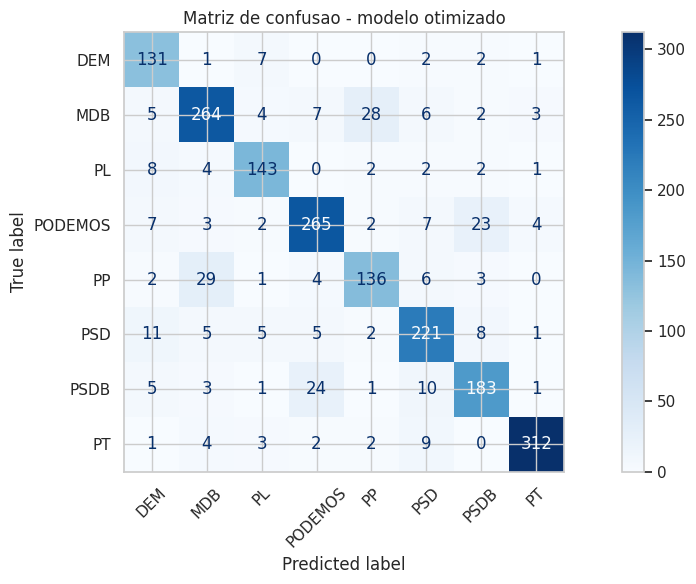

In [30]:
cm = confusion_matrix(y_test, y_pred_test, labels=best_model.named_steps['clf'].classes_)
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_).plot(ax=ax, cmap='Blues', xticks_rotation=45)
ax.set(title='Matriz de confusao - modelo otimizado')
plt.tight_layout()


A leitura da matriz de confusão considera a diagonal principal como região de acertos; valores elevados fora dessa diagonal revelam pares de partidos frequentemente confundidos, muitas vezes por afinidade temática. Quando uma classe acumula falsos negativos, ajustes de `class_weight` ou coleta adicional de exemplos podem mitigar o problema.

### 7.3. Interpretar os termos que mais contribuem para cada partido na Regressão Logística
Os coeficientes do classificador são ordenados para cada classe, destacando os termos com maior peso positivo e permitindo examinar se as decisões se baseiam em tópicos substantivos.

In [31]:
tfidf_vect = best_model.named_steps['tfidf']
clf = best_model.named_steps['clf']
feature_names = np.array(tfidf_vect.get_feature_names_out())

palavras_por_partido = {}
for classe, coeficientes in zip(clf.classes_, clf.coef_):
    top_indices = np.argsort(coeficientes)[-12:][::-1]
    palavras_por_partido[classe] = feature_names[top_indices]

pd.DataFrame(palavras_por_partido)


,DEM,MDB,PL,PODEMOS,PP,PSD,PSDB,PT
0,vanguarda,parlamentar unidos,parlamentar vanguarda,parlamentar psl,parlamentar unidos,parlamentar republicanos,psl,da resistencia
1,parlamentar vanguarda,unidos pelo,vanguarda,psl,unidos pelo,republicanos,parlamentar psl,resistencia democratica
2,democratas,unidos,vanguarda para,parlamentar juntos,unidos,sr pela,juntos pelo,parlamentar da
3,presidente bloco,pelo brasil,vanguarda pela,juntos pelo,pelo brasil,sr para,parlamentar juntos,resistencia
4,vanguarda para,sr presidente,principalmente,juntos,progressistas,republicanos para,juntos,democratica
5,em relacao,pelo,tambem,psl para,sra bloco,grosso do,gente,democratica para
6,na verdade,brasil,aqui,obrigado,brasil,senador,psl pela,paul bloco
7,verdade,brasil para,sr bloco,muito,pelo,amapa,psl para,democratica pela
8,roraima,portanto,micro,psl pode,brasil para,republicanos pela,pode psl,sr jean
9,senador,brasil pela,mato,psl pela,eu,exa,parlamentar pode,trabalhadores


### 7.4. Explicabilidade via valores SHAP
Valores SHAP calculados sobre a representação TF-IDF oferecem visão complementar da importância dos termos no conjunto de teste, reforçando a interpretabilidade e a prestação de contas do modelo.

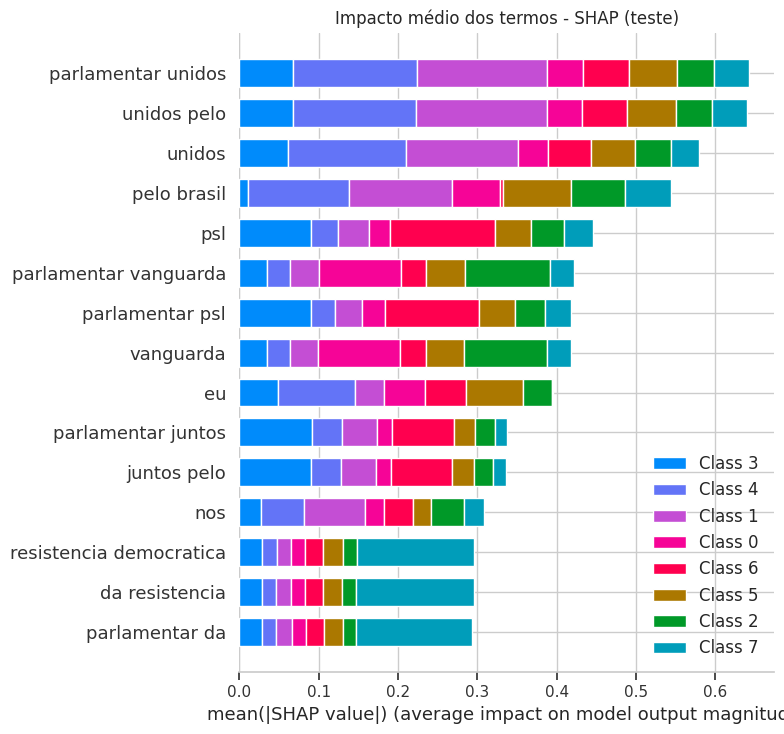

In [32]:
try:
    import shap
except ImportError:
    print('Instale a biblioteca shap para gerar as explicações: pip install shap')
else:
    tfidf_vect = best_model.named_steps['tfidf']
    clf = best_model.named_steps['clf']
    X_train_tfidf = tfidf_vect.transform(X_train)
    background = shap.utils.sample(X_train_tfidf, 200, random_state=42)
    explainer = shap.LinearExplainer(clf, background)

    amostra_teste = X_test.sample(min(30, len(X_test)), random_state=42)
    shap_values = explainer(tfidf_vect.transform(amostra_teste))
    shap.summary_plot(
        shap_values,
        feature_names=tfidf_vect.get_feature_names_out(),
        max_display=15,
        show=False
    )
    plt.title('Impacto médio dos termos - SHAP (teste)')
    plt.tight_layout()

## 8. Análise temática não supervisionada
Para complementar a classificação supervisionada por partido, aplicamos um modelo não supervisionado de tópicos (NMF) sobre o corpus de discursos. O objetivo é identificar agendas dominantes sem depender de rótulos, reforçando o storytelling sobre a atuação legislativa e oferecendo uma camada adicional de accountability.

### 8.1 Preparar amostra e texto para o modelo de tópicos
Seleciona-se uma amostra aleatória do corpus para acelerar o ajuste, aplicando limpeza básica e remoção de menções explícitas a partido e UF. A vetorização usa TF-IDF com unigrama e bigrama, privilegiando termos informativos em português.

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Função de limpeza inspirada na etapa supervisionada
partidos_lista = sorted(df['Partido'].dropna().str.lower().unique().tolist())
ufs_lista = sorted(df['UF'].dropna().str.lower().unique().tolist())
regex_partidos = re.compile(r'\b(' + '|'.join(map(re.escape, partidos_lista)) + r')\b') if partidos_lista else None
regex_ufs = re.compile(r'\b(' + '|'.join(map(re.escape, ufs_lista)) + r')\b') if ufs_lista else None

# Inclui NomeAutor para possíveis análises relacionais
cols_amostra = [col for col in ['Data', 'Partido', 'UF', 'NomeAutor', 'TextoDiscursoIntegral'] if col in df.columns]
amostra = df[cols_amostra].dropna(subset=['TextoDiscursoIntegral']).copy()
amostra = amostra[amostra['TextoDiscursoIntegral'].str.len() > 0]
if len(amostra) > 5000:
    amostra = amostra.sample(5000, random_state=42)

def limpar_texto_topicos(texto):
    texto = str(texto).lower()
    texto = re.sub(r'\d+', ' ', texto)
    texto = re.sub(r'[^\w\s]', ' ', texto)
    if regex_partidos:
        texto = regex_partidos.sub(' ', texto)
    if regex_ufs:
        texto = regex_ufs.sub(' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

amostra['texto_limpo'] = amostra['TextoDiscursoIntegral'].apply(limpar_texto_topicos)

try:
    from nltk.corpus import stopwords
    try:
        stopwords_pt = stopwords.words('portuguese')
    except LookupError:
        import nltk
        nltk.download('stopwords', quiet=True)
        stopwords_pt = stopwords.words('portuguese')
except Exception:
    stopwords_pt = []

vectorizer = TfidfVectorizer(
    max_features=15000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words=stopwords_pt if stopwords_pt else None
)
X_tfidf = vectorizer.fit_transform(amostra['texto_limpo'])
print(f'Amostra usada no NMF: {X_tfidf.shape[0]} discursos, {X_tfidf.shape[1]} termos')

### 8.2 Descobrir e nomear temas com NMF
Um modelo NMF com oito componentes é ajustado para decompor a matriz TF-IDF. Os termos de maior peso em cada componente ajudam a interpretar os temas latentes (saúde, economia, infraestrutura, educação, etc.).

In [34]:
n_topics = 8
nmf_model = NMF(n_components=n_topics, random_state=42, init='nndsvd')
W = nmf_model.fit_transform(X_tfidf)
H = nmf_model.components_

feature_names = vectorizer.get_feature_names_out()
termos_por_tema = {}
for i, comp in enumerate(H):
    top_indices = comp.argsort()[-12:][::-1]
    termos_por_tema[f'Tema_{i+1}'] = feature_names[top_indices]

termos_por_tema_df = pd.DataFrame(termos_por_tema)
termos_por_tema_df

,Tema_1,Tema_2,Tema_3,Tema_4,Tema_5,Tema_6,Tema_7,Tema_8
0,governo,bancada,nº,parlamentar resistência,parlamentar unidos,kajuru,todos,gente
1,país,orientar,art,resistência democrática,unidos brasil,parlamentar juntos,mulheres,educação
2,reforma,orientar bancada,lei,resistência,unidos,juntos brasil,aqui,então
3,brasil,orienta,projeto,democrática,brasil,juntos,sessão,aqui
4,estado,sim,emenda,sr paulo,amin,jorge kajuru,quero,porque
5,previdência,bancada videoconferência,exa,paulo,esperidião,senador,federal,vai
6,milhões,voto,câmara,rocha bloco,bloco parlamentar,jorge,senador,acho
7,povo,videoconferência,senado,paulo rocha,esperidião amin,girão,senado,aí
8,hoje,voto sim,federal,democrática orientar,parlamentar,parlamentar,mulher,pessoas
9,bilhões,brasil orientar,senador,rocha,amin bloco,bloco parlamentar,grande,ter


### 8.3 Evolução temporal dos temas
Cada discurso é associado ao tema dominante (maior peso em `W`). A distribuição mensal revela como os tópicos ganham ou perdem relevância ao longo da legislatura, permitindo relacioná-los a eventos públicos.

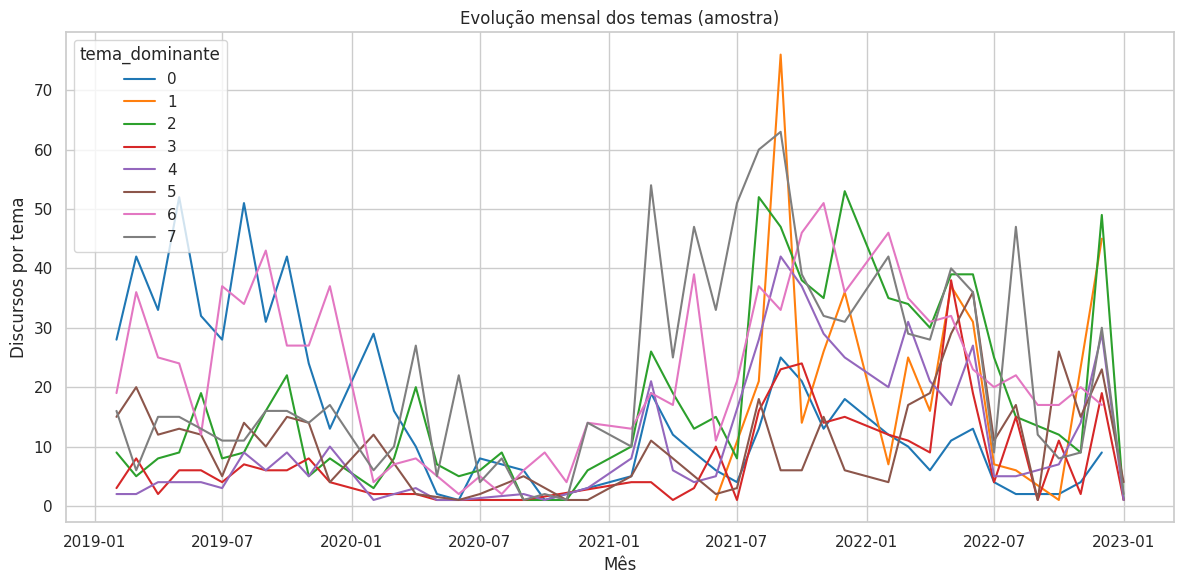

In [35]:
dominante = W.argmax(axis=1)
amostra = amostra.assign(
    tema_dominante=dominante,
    mes=amostra['Data'].dt.to_period('M').dt.to_timestamp()
)

temas_long = (
    amostra
    .groupby(['mes', 'tema_dominante'])
    .size()
    .reset_index(name='qtd')
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=temas_long, x='mes', y='qtd', hue='tema_dominante', palette='tab10')
plt.title('Evolução mensal dos temas (amostra)')
plt.ylabel('Discursos por tema')
plt.xlabel('Mês')
plt.tight_layout()

### 8.4 Distribuição de temas por partido
A matriz partido × tema mostra o percentual de discursos de cada sigla em cada tópico, útil para verificar alinhamento entre agenda e atuação discursiva sem depender de rótulos na modelagem.

In [36]:
matriz_partido = pd.crosstab(amostra['Partido'], amostra['tema_dominante'], normalize='index') * 100
matriz_partido.round(2)

tema_dominante,0,1,2,3,4,5,6,7
Partido,,,,,,,,
AVANTE,0.00,0.00,16.67,0.00,0.00,16.67,50.00,16.67
CIDADANIA,11.69,11.04,20.78,0.00,0.65,15.58,28.57,11.69
DEM,20.00,5.88,39.22,0.39,2.75,3.92,24.71,3.14
MDB,11.49,7.85,13.60,0.77,40.80,1.53,11.30,12.64
NOVO,7.69,7.69,46.15,0.00,0.00,0.00,15.38,23.08
PATRIOTA,20.00,30.00,0.00,0.00,0.00,40.00,10.00,0.00
PCdoB,0.00,0.00,75.00,0.00,0.00,0.00,12.50,12.50
PDT,15.52,12.07,21.55,0.00,4.31,2.59,25.86,18.10
PL,4.63,17.44,19.57,2.49,2.14,3.20,32.03,18.51


### 8.5 Visualizações Sankey de partidos, senadores e temas
Os diagramas Sankey sintetizam as conexões entre partidos, senadores e temas dominantes encontrados pelo modelo NMF. A visualização facilita identificar quais siglas e quais parlamentares concentram determinados tópicos, reforçando a leitura conjunta das abordagens supervisionada e não supervisionada.

In [37]:
try:
    import plotly.graph_objects as go
except ImportError:
    print('Instale plotly para gerar os Sankeys: pip install plotly')
else:
    if 'tema_dominante' not in amostra.columns:
        print('Execute as células anteriores da seção 8 para gerar os tópicos antes do Sankey.')
    else:
        # rótulos de temas com termos mais representativos (top 3)
        tema_labels = []
        for i in range(W.shape[1]):
            termos_cur = termos_por_tema.get(f'Tema_{i+1}', [])
            termos_str = ', '.join(list(termos_cur[:3])) if len(termos_cur) > 0 else ''
            tema_labels.append(f'Tema {i+1}: ' + termos_str)

        # Sankey partido -> tema
        df_partido = amostra.groupby(['Partido', 'tema_dominante']).size().reset_index(name='qtd')
        nodos_partido = df_partido['Partido'].dropna().unique().tolist()
        nodes = nodos_partido + tema_labels
        idx = {label: i for i, label in enumerate(nodes)}
        sources = df_partido['Partido'].map(idx)
        targets = df_partido['tema_dominante'].apply(lambda x: idx[tema_labels[x]])
        valores = df_partido['qtd']

        fig1 = go.Figure(go.Sankey(
            node=dict(label=nodes, pad=12, thickness=12),
            link=dict(source=sources, target=targets, value=valores)
        ))
        fig1.update_layout(title='Fluxo Partido → Tema (NMF)')
        fig1.show()

        # Sankey senadores -> tema (limita aos 12 mais frequentes na amostra)
        if 'NomeAutor' in amostra.columns:
            top_senadores = amostra['NomeAutor'].value_counts().head(12).index.tolist()
            df_sen = amostra[amostra['NomeAutor'].isin(top_senadores)]
            df_sen = df_sen.groupby(['NomeAutor', 'tema_dominante']).size().reset_index(name='qtd')
            nodos_sen = top_senadores
            nodes2 = nodos_sen + tema_labels
            idx2 = {label: i for i, label in enumerate(nodes2)}
            sources2 = df_sen['NomeAutor'].map(idx2)
            targets2 = df_sen['tema_dominante'].apply(lambda x: idx2[tema_labels[x]])
            valores2 = df_sen['qtd']

            fig2 = go.Figure(go.Sankey(
                node=dict(label=nodes2, pad=12, thickness=12),
                link=dict(source=sources2, target=targets2, value=valores2)
            ))
            fig2.update_layout(title='Fluxo Senadores → Tema (NMF)')
            fig2.show()
        else:
            print('Coluna NomeAutor não disponível para o Sankey de senadores.')

Coluna NomeAutor não disponível para o Sankey de senadores.


## 9. Discussão Crítica
O volume de discursos concentra-se entre 2020 e 2022, acompanhando momentos de crise sanitária e o ciclo eleitoral, o que sugere relação direta entre eventos críticos e maior uso da tribuna. Autores como Izalci Lucas e Randolfe Rodrigues assumem protagonismo, indicando figuras centrais na agenda legislativa. A extensão dos discursos apresenta grande variabilidade, e partidos do campo ideológico identificado como “centrão” compartilham vocabulário e temas com outras legendas, o que dificulta a separação automática. Ainda assim, o classificador produz desempenho elevado, mas a proximidade temática exige cautela ao interpretar diferenças sutis de precisão e revocação. A análise não supervisionada de tópicos reforça essa leitura ao mostrar agendas transversais (p. ex., saúde ou economia) que atravessam siglas, servindo de alerta para limites da atribuição partidária baseada apenas em texto.

## 10. Accountability e Governança
O classificador supervisionado pode subsidiar mecanismos de prestação de contas ao verificar coerência entre fala e agenda partidária; discrepâncias devem acionar investigação por jornalistas, conselhos de transparência ou controladorias internas. A modelagem temática não supervisionada adiciona uma camada de auditoria: temas que emergem com força em discursos de um partido, mas sem correspondência em sua plataforma, indicam desalinhamento narrativo. A utilização das duas abordagens precisa ser acompanhada de documentação e publicação aberta dos dados, do código e das métricas, assegurando reprodutibilidade e auditabilidade. Recomenda-se monitorar continuamente desempenho e vieses para que as ferramentas fortaleçam a governança democrática em vez de legitimar narrativas desinformadas.